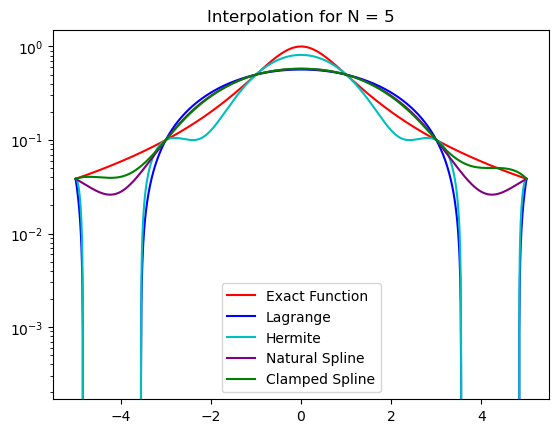

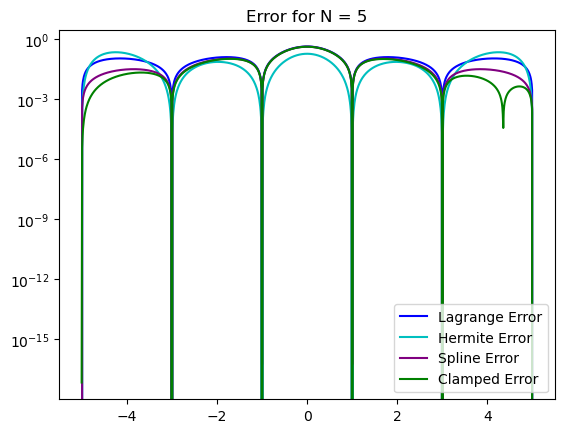

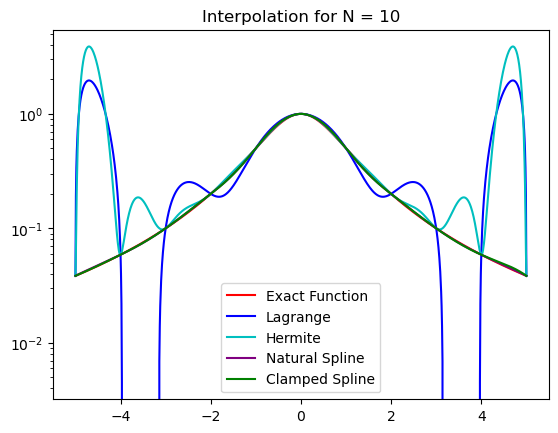

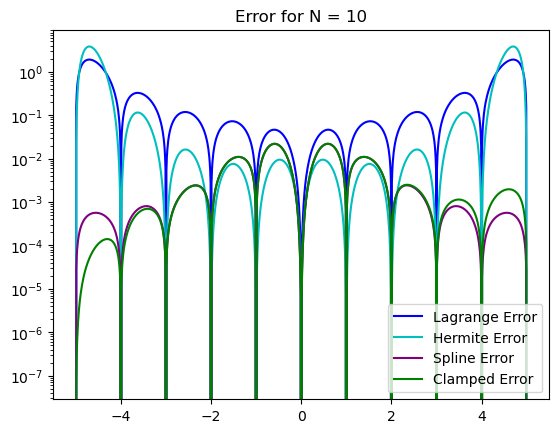

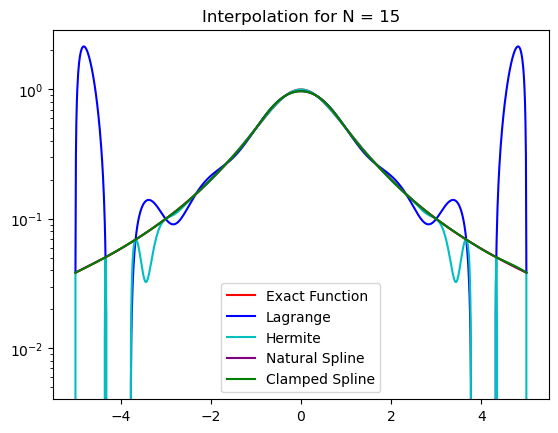

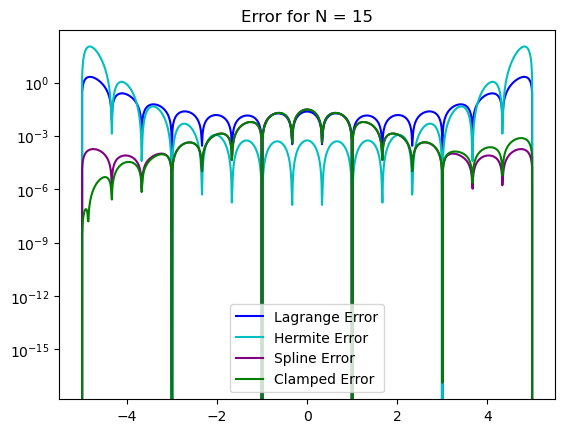

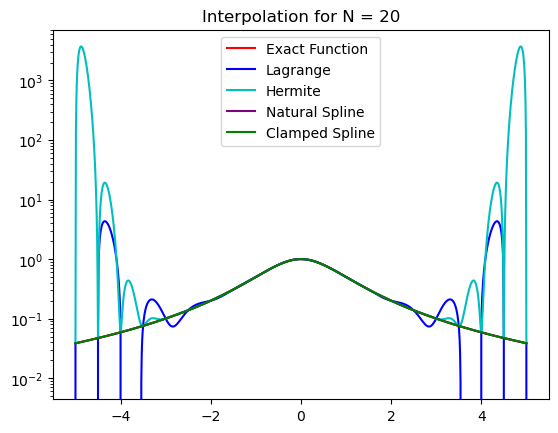

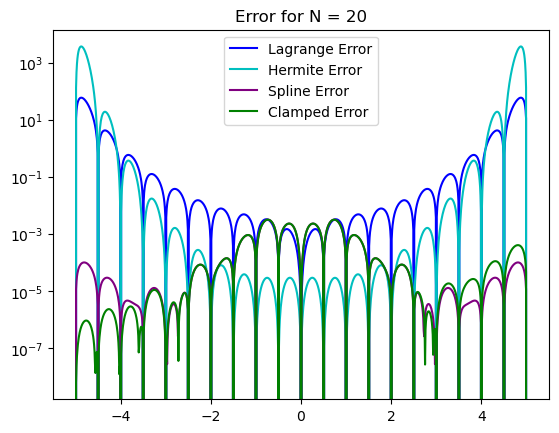

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
import math
from numpy.linalg import inv
from numpy.linalg import norm


def driver():
    f = lambda x: 1./(1.+x**2)
    fp = lambda x: -2*x/(1.+x**2)**2
    
    ''' interval'''
    a = -5
    b = 5
    
    N = [5, 10, 15, 20]
    
    for i in N:
        N = i
        ''' create equispaced interpolation nodes'''
        xint = np.linspace(a,b,N+1)
        ''' create interpolation data'''
        yint = np.zeros(N+1)
        ypint = np.zeros(N+1)
        for jj in range(N+1):
            yint[jj] = f(xint[jj])
            ypint[jj] = fp(xint[jj])


        ''' create points for evaluating the Lagrange interpolating polynomial'''
        Neval = 1000
        xeval = np.linspace(a,b,Neval+1)
        yevalL = np.zeros(Neval+1)
        yevalH = np.zeros(Neval+1)

        for kk in range(Neval+1):
            yevalL[kk] = eval_lagrange(xeval[kk],xint,yint,N)
            yevalH[kk] = eval_hermite(xeval[kk],xint,yint,ypint,N)


        ''' create vector with exact values'''
        fex = np.zeros(Neval+1)
        for kk in range(Neval+1):
            fex[kk] = f(xeval[kk])

        xeval = np.linspace(xint[0],xint[N],Neval+1)
        (M,C,D) = create_natural_spline(yint,xint,N)
        (M1,C1,D1) = create_clamped_spline(yint, xint, N, fp(a), fp(b))
        #print('M =', M)
        # print('C =', C)
        # print('D=', D)
        yeval_cub = eval_cubic_spline(xeval,Neval,xint,N,M,C,D)
        yeval_clamp = eval_cubic_spline(xeval, Neval, xint, N, M1, C1, D1)
        # print('yeval = ', yeval)
        ''' evaluate f at the evaluation points'''
        fex = f(xeval)
        nerr = norm(fex-yeval_cub)
        clamp_err = norm(fex-yeval_clamp)


        plt.figure()
        plt.plot(xeval,fex,'r',label='Exact Function')
        plt.plot(xeval,yevalL,'b',label='Lagrange')
        plt.plot(xeval,yevalH,'c',label='Hermite')
        plt.plot(xeval,yeval_cub,'purple',label='Natural Spline')
        plt.plot(xeval, yeval_clamp, 'green', label = 'Clamped Spline')
        plt.title('Interpolation for N = %d' %N )
        plt.legend()
        plt.semilogy()
        plt.show()
        errL = abs(yevalL-fex)
        errH = abs(yevalH-fex)
        errS = abs(yeval_cub-fex)
        errC = abs(yeval_clamp -fex)
        plt.figure()
        plt.semilogy(xeval,errL,'b',label='Lagrange Error')
        plt.semilogy(xeval,errH,'c',label='Hermite Error')
        plt.semilogy(xeval,errS,'purple',label='Spline Error')
        plt.semilogy(xeval,errC,'green',label='Clamped Error')
        plt.title('Error for N = %d' %N )
        plt.legend()
        plt.show()


def eval_hermite(xeval,xint,yint,ypint,N):
    ''' Evaluate all Lagrange polynomials'''
    lj = np.ones(N+1)
    for count in range(N+1):
        for jj in range(N+1):
            if (jj != count):
                lj[count] = lj[count]*(xeval - xint[jj])/(xint[count]-xint[jj])
                
    ''' Construct the l_j'(x_j)'''
    lpj = np.zeros(N+1)
    # lpj2 = np.ones(N+1)
    for count in range(N+1):
        for jj in range(N+1):
            if (jj != count):
                # lpj2[count] = lpj2[count]*(xint[count] - xint[jj])
                lpj[count] = lpj[count]+ 1./(xint[count] - xint[jj])
    yeval = 0.
    for jj in range(N+1):
        Qj = (1.-2.*(xeval-xint[jj])*lpj[jj])*lj[jj]**2
        Rj = (xeval-xint[jj])*lj[jj]**2
        # if (jj == 0):
        # print(Qj)
        # print(Rj)
        # print(Qj)
        # print(xeval)
        # return
        yeval = yeval + yint[jj]*Qj+ypint[jj]*Rj
        
    return(yeval)


def eval_lagrange(xeval,xint,yint,N):
    lj = np.ones(N+1)
    for count in range(N+1):
        for jj in range(N+1):
            if (jj != count):
                lj[count] = lj[count]*(xeval - xint[jj])/(xint[count]-xint[jj])
                
    yeval = 0.
    for jj in range(N+1):
        yeval = yeval + yint[jj]*lj[jj]
        
    return(yeval)

def create_natural_spline(yint,xint,N):
    # create the right hand side for the linear system
    b = np.zeros(N+1)
    # vector values
    h = np.zeros(N+1)
    for i in range(1,N):
        hi = xint[i]-xint[i-1]
        hip = xint[i+1] - xint[i]
        b[i] = (yint[i+1]-yint[i])/hip - (yint[i]-yint[i-1])/hi
        h[i-1] = hi
        h[i] = hip
    # create matrix so you can solve for the M values
    # This is made by filling one row at a time
    A = np.zeros((N+1,N+1))
    A[0][0] = 1.0
    for j in range(1,N):
        A[j][j-1] = h[j-1]/6
        A[j][j] = (h[j]+h[j-1])/3
        A[j][j+1] = h[j]/6
        
    A[N][N] = 1
    
    Ainv = inv(A)
    
    M = Ainv.dot(b)
    # Create the linear coefficients
    C = np.zeros(N)
    D = np.zeros(N)
    for j in range(N):
        C[j] = yint[j]/h[j]-h[j]*M[j]/6
        D[j] = yint[j+1]/h[j]-h[j]*M[j+1]/6
    return(M,C,D)

def eval_local_spline(xeval,xi,xip,Mi,Mip,C,D):
# Evaluates the local spline as defined in class
# xip = x_{i+1}; xi = x_i
# Mip = M_{i+1}; Mi = M_i
    hi = xip-xi
    yeval = (Mi*(xip-xeval)**3 +(xeval-xi)**3*Mip)/(6*hi) + C*(xip-xeval) + D*(xeval-xi)
    
    return yeval


def eval_cubic_spline(xeval,Neval,xint,Nint,M,C,D):
    yeval = np.zeros(Neval+1)
    for j in range(Nint):
        '''find indices of xeval in interval (xint(jint),xint(jint+1))'''
        '''let ind denote the indices in the intervals'''
        atmp = xint[j]
        btmp= xint[j+1]
        
    # find indices of values of xeval in the interval
        ind= np.where((xeval >= atmp) & (xeval <= btmp))
        xloc = xeval[ind]
    # evaluate the spline
        yloc = eval_local_spline(xloc,atmp,btmp,M[j],M[j+1],C[j],D[j])
        # print('yloc = ', yloc)
        # copy into yeval
        yeval[ind] = yloc
        
    return(yeval)

def create_clamped_spline(yint,xint,N, b0, bn):
    
    # create the right hand side for the linear system
    b = np.zeros(N+1)
    # vector values
    h = np.zeros(N+1)
    for i in range(1,N):
        hi = xint[i]-xint[i-1]
        hip = xint[i+1] - xint[i]
        b[i] = (yint[i+1]-yint[i])/hip - (yint[i]-yint[i-1])/hi
        h[i-1] = hi
        h[i] = hip
        
    b[0] = -b0 + (yint[1] - yint[0])/h[0]
    b[N] = -bn + (yint[N] - yint[N-1])/h[N-1]
    # create matrix so you can solve for the M values
    # This is made by filling one row at a time
    A = np.zeros((N+1,N+1))
    A[0][0] = h[0]/3
    A[0][1] = h[0]/6
    for j in range(1,N):
        A[j][j-1] = h[j-1]/6
        A[j][j] = (h[j]+h[j-1])/3
        A[j][j+1] = h[j]/6
        
    A[N][N-1] = h[N-1]/6
    A[N][N] = h[N-1]/3
    
    Ainv = inv(A)
    
    M = Ainv.dot(b)
    # Create the linear coefficients
    C = np.zeros(N)
    D = np.zeros(N)
    for j in range(N):
        C[j] = yint[j]/h[j]-h[j]*M[j]/6
        D[j] = yint[j+1]/h[j]-h[j]*M[j+1]/6
    return(M,C,D)

driver()

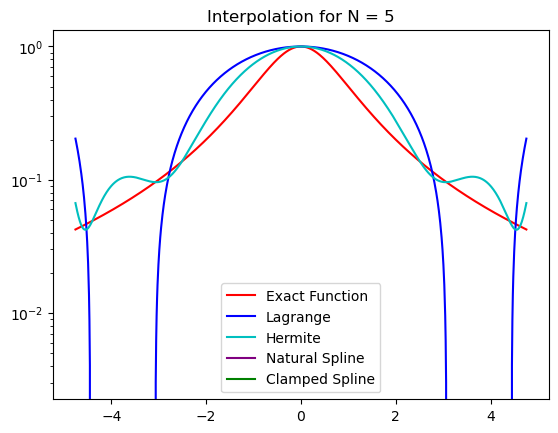

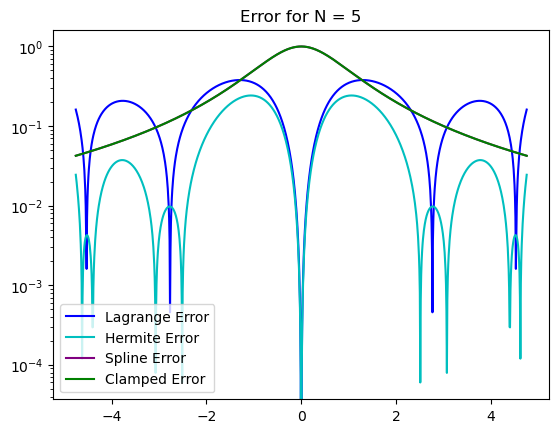

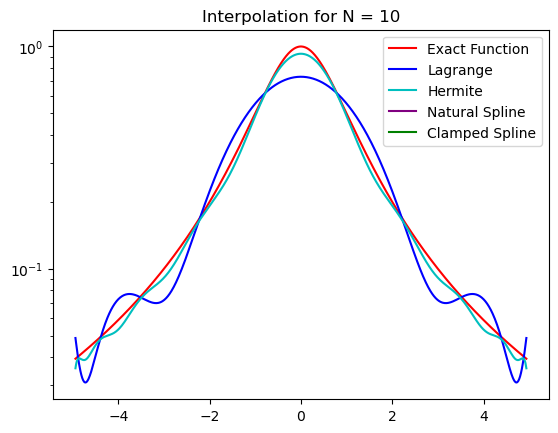

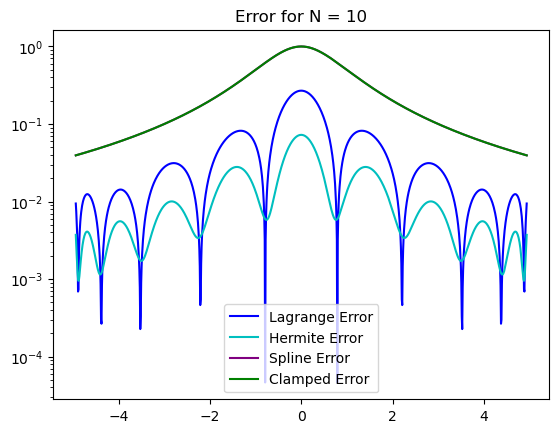

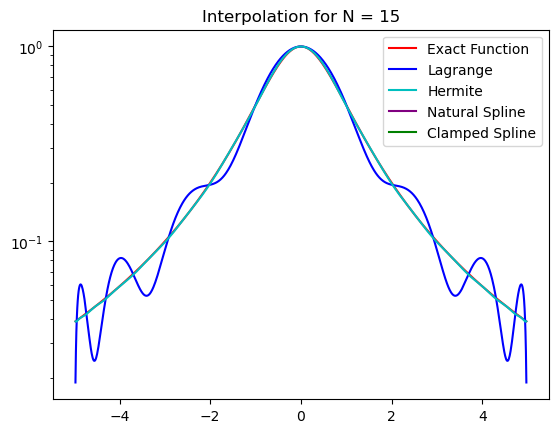

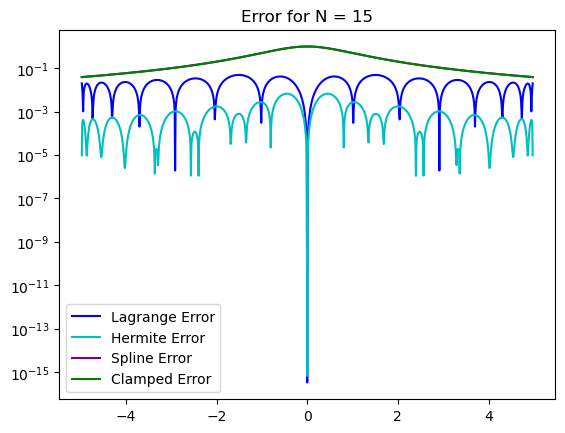

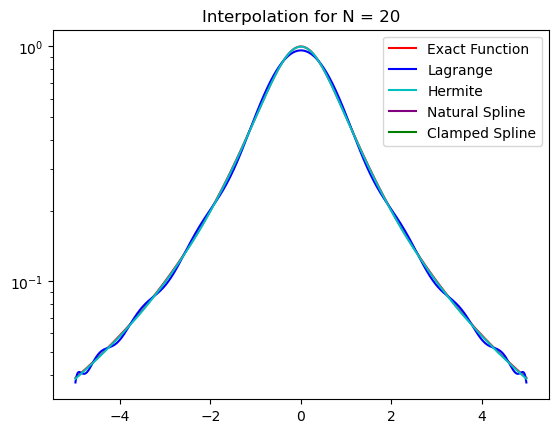

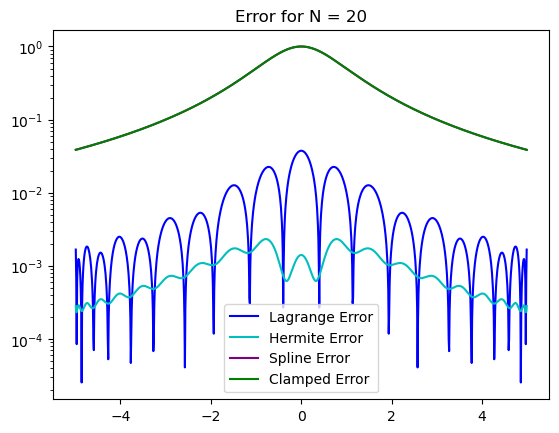

In [54]:
def driver2():
    f = lambda x: 1./(1.+x**2)
    fp = lambda x: -2*x/(1.+x**2)**2
    
    ''' interval'''
    a = -5
    b = 5
    
    N = [5, 10, 15, 20]
    
    
    for i in N:
        N = i
        # ''' create equispaced interpolation nodes'''
        # xint = np.linspace(a,b,N+1)
        # ''' create interpolation data'''
        # yint = np.zeros(N+1)
        # ypint = np.zeros(N+1)
        xint = np.cos((2*np.arange(1, N+1) - 1)*np.pi/(2*(N)))
        xint = 5*xint
        yint = []
        ypint = []
        for i in xint:
            y = f(i)
            yp = fp(i)
            yint.append(y)
            ypint.append(yp)


        ''' create points for evaluating the Lagrange interpolating polynomial'''
        Neval = 1000
        xeval = np.linspace(a,b,Neval+1)
        yevalL = np.zeros(Neval+1)
        yevalH = np.zeros(Neval+1)

        for kk in range(Neval+1):
            yevalL[kk] = eval_lagrange(xeval[kk],xint,yint,N-1)
            yevalH[kk] = eval_hermite(xeval[kk],xint,yint,ypint,N-1)


        ''' create vector with exact values'''
        fex = np.zeros(Neval+1)
        for kk in range(Neval+1):
            fex[kk] = f(xeval[kk])

        xeval = np.linspace(xint[0],xint[N-1],Neval+1)
        (M,C,D) = create_natural_spline(yint,xint,N-1)
        (M1,C1,D1) = create_clamped_spline(yint, xint, N-1, fp(a), fp(b))
        #print('M =', M)
        # print('C =', C)
        # print('D=', D)
        yeval_cub = eval_cubic_spline(xeval,Neval,xint,N-1,M,C,D)
        yeval_clamp = eval_cubic_spline(xeval, Neval, xint, N-1, M1, C1, D1)
        # print('yeval = ', yeval)
        ''' evaluate f at the evaluation points'''
        fex = f(xeval)
        nerr = norm(fex-yeval_cub)
        clamp_err = norm(fex-yeval_clamp)


        plt.figure()
        plt.plot(xeval,fex,'r',label='Exact Function')
        plt.plot(xeval,yevalL,'b',label='Lagrange')
        plt.plot(xeval,yevalH,'c',label='Hermite')
        plt.plot(xeval,yeval_cub,'purple',label='Natural Spline')
        plt.plot(xeval, yeval_clamp, 'green', label = 'Clamped Spline')
        plt.title('Interpolation for N = %d' %N )
        plt.legend()
        plt.semilogy()
        plt.show()
        errL = abs(yevalL-fex)
        errH = abs(yevalH-fex)
        errS = abs(yeval_cub-fex)
        errC = abs(yeval_clamp -fex)
        plt.figure()
        plt.semilogy(xeval,errL,'b',label='Lagrange Error')
        plt.semilogy(xeval,errH,'c',label='Hermite Error')
        plt.semilogy(xeval,errS,'purple',label='Spline Error')
        plt.semilogy(xeval,errC,'green',label='Clamped Error')
        plt.title('Error for N = %d' %N )
        plt.legend()
        plt.show()
        
driver2()